In [1]:
import datetime
import os
import sys
import pickle
import random
from dataclasses import dataclass

sys.path.append('../')

from scripts.filtration import FiltrationClustering
from scripts.clustering import leiden

import networkx as nx
import igraph as ig

import folium
import geopy.distance
import igraph
import numpy as np
import osmnx as ox
import pandas as pd
import requests
from ortools.sat.python import cp_model
from sklearn.neighbors import KDTree
# from sklearn.cluster import KMeans
import kmedoids
import leidenalg as la

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from multiprocessing import Pool
from joblib import Parallel, delayed

Загрузка данных

In [2]:
df = pd.read_excel('./data/выгрузка такси ПАО ЦА.XLSX')

In [3]:
# df_mos = df[df.apply(lambda r:'Москва' in r['Адрес отправления'] or 'Московская область' in r['Адрес отправления'], axis=1)]
df_mos = df[df.apply(lambda r: 'Москва' in r['Адрес отправления'], axis=1)]
df_mos = df_mos[df_mos.apply(lambda r: 'Москва' in r['Адрес прибытия'], axis=1)]

df_mos = df_mos[df_mos.apply(lambda r: r['Количество точек в маршруте'] == 2, axis=1)]
df_mos = df_mos[df_mos.apply(lambda r: r['Вид тарифа'] in {'Эконом', 'Комфорт'}, axis=1)]

# фильтр пустых значений
df_mos = df_mos[df_mos.apply(lambda r: r['Адрес отправления'] not in {'Москва, , '}, axis=1)]
df_mos = df_mos[df_mos.apply(lambda r: r['Адрес прибытия'] not in {'Москва, , ', 'Москва, '}, axis=1)]

In [4]:
df_mos = df_mos[df_mos.apply(lambda r: '23.01.2025' == r['Желаемая дата отправления'], axis=1)]

del df

addresses = {q for q in df_mos['Адрес отправления'].unique()}
addresses.update({q for q in df_mos['Адрес прибытия'].unique()})

len(addresses)

145

Получение координат точек

In [5]:
@dataclass
class YandexGeocoder:
    api_key: str = None
    geocoder_url: str = 'https://geocode-maps.yandex.ru/1.x'

    def adress_to_geopoint(self, address: str) -> tuple[float, float] | None:
        # Преобразование адреса в геокоординаты в формате DataLens

        response = requests.get(self.geocoder_url, params={
            'apikey': self.api_key,
            'geocode': address,
            'format': 'json',
        })
        response.raise_for_status()

        result = response.json()['response']['GeoObjectCollection']['featureMember']
        if not result:
            return None

        lat, lon = result[0]['GeoObject']['Point']['pos'].split(' ')
        return lat, lon

    def _to_datalens_format(self, lon, lat):
        return f'[{lon},{lat}]'

Загрузка координат из файла ./data/address.pkl

In [6]:
coords = {}

# geocoder = YandexGeocoder()
# for add in tqdm(addresses):
#     res = geocoder.adress_to_geopoint(add)
#     if res is None:
#         print(add)
#         continue
#     coords[add] = res


with open('./data/address.pkl', 'rb') as f:
    coords_1 = pickle.load(f)
coords_1: dict = coords_1
for k, v in coords_1.items():
    coords[k] = v

In [7]:
# coords

In [8]:
x0, y0 = np.mean([v[0] for v in coords.values()]), np.mean([v[1] for v in coords.values()])
r = max(geopy.distance.geodesic((x0, y0), (v[0], v[1])).km for v in coords.values()) * 1000
x0, y0, r

(37.572079773662544, 55.73633819753086, 50242.55738057921)

load graph


In [9]:
def get_graph(x, y, r=10000) -> nx.Graph:
    # name = f'{x:.2f}_{y:.2f}.pkl'
    path = f'./data/graphs/{x:.2f}_{y:.2f}_{r}.pkl'
    if os.path.exists(path):
        with open(path, 'rb') as fp:
            g: nx.Graph = pickle.load(fp)
            fp.close()
    else:
        g = _get_gr(x, y, r)
        with open(path, 'wb') as fp:
            pickle.dump(g, fp)
            fp.close()
    assert g is not None
    g.remove_edges_from(nx.selfloop_edges(g))
    return g


def _get_gr(x, y, r):
    graph = ox.graph_from_point(
        center_point=(y, x),
        network_type='drive',
        simplify=True,
        dist=r
    )
    # polygon_boundary = gdf.unary_union
    # graph = ox.graph_from_polygon(polygon_boundary,
    #                               network_type='drive',
    #                               simplify=True)
    H = nx.Graph()
    # Добавляем рёбра в новый граф, копируя только веса
    for u, d in graph.nodes(data=True):
        H.add_node(u, x=d['x'], y=d['y'])
    for u, v, d in graph.edges(data=True):
        if u == v:
            continue
        H.add_edge(u, v, length=d['length'])
    del graph
    return H

In [10]:
g = get_graph(x0, y0, r).to_undirected()
print(len(g.nodes), len(g.edges))

88610 118473


In [11]:
# описание сущности заказа

@dataclass
class Delivery:
    id: str
    tarif: str
    canceled: bool
    create_data: datetime.datetime
    start_time: datetime.datetime
    source: str
    target: str
    source_coords: tuple[float, float]
    target_coords: tuple[float, float]
    source_nodes: list[int]
    target_nodes: list[int]
    km: float
    real_km: float
    cost: float
    fix_min_cost: float
    real_cost: float

In [12]:
node2number = {u: i for i, u in enumerate(g.nodes())}
number2node = {i: u for i, u in enumerate(g.nodes())}
tree = KDTree([[d['x'], d['y']] for u, d in g.nodes(data=True)], leaf_size=10)
# получение ближайшей ноды графа по координатам
def get_near_nodes(g: nx.Graph, coords, k=1) -> list[int]:
    x, y = coords
    dst, res = tree.query([[x, y]], k=k)
    print(dst[0][0])
    return [number2node[u] for u in res[0]]

Парсинг всех заявок

In [13]:
deliveries: list[Delivery] = []
for _, r in tqdm(df_mos.iterrows(), total=len(df_mos)):
    canceled = r['Статус поездки'] == 'Отменено'
    d = Delivery(
        id=r['Номер заявки'],
        tarif=r['Вид тарифа'],
        canceled=canceled,
        create_data=datetime.datetime.strptime(r['Дата и время создания заявки'], '%d.%m.%Y %H:%M:%S'),
        start_time=datetime.datetime.strptime(r['Желаемая дата отправления'] + " " + r['Желаемое время отправления'],
                                              '%d.%m.%Y %H:%M:%S'),
        source=r['Адрес отправления'],
        target=r['Адрес прибытия'],
        source_coords=coords[r['Адрес отправления']],
        target_coords=coords[r['Адрес прибытия']],
        source_nodes=get_near_nodes(g, coords[r['Адрес отправления']]),
        target_nodes=get_near_nodes(g, coords[r['Адрес прибытия']]),
        km=r['Предварительный километраж в заявке, км'],
        real_km=r['Фактический километраж в поездке, км'] if not canceled else 0,
        cost=r['Предварительная стоимость в заявке, руб'],
        fix_min_cost=r['Фиксированная стоимость минимально расчетного тарифа по такси'],
        real_cost=r['Фактическая стоимость в поездке, руб'] if not canceled else 0
    )
    deliveries.append(d)

  0%|          | 0/146 [00:00<?, ?it/s]

0.0026447178015813833
0.00401449085314941
0.0010116554057532643
0.0005845251833757793
0.0010116554057532643
0.001633573775498319
0.0007297158351021204
0.0016618132747018846
0.000963534047138516
0.0018235228241004463
0.004551772187844438
0.001972918561419475
0.0010116554057532643
0.0021119404915869683
0.0010116554057532643
0.002398453656006221
0.0009009589613325834
0.0008123115966197537
0.0009009589613325834
0.005307414433599209
0.0009009589613325834
0.002407010837116554
0.0010116554057532643
0.0011957413850814977
0.0010116554057532643
0.0023190353253063605
0.000963534047138516
0.0014648612664662222
0.0010116554057532643
0.0011320517876879557
0.0010116554057532643
0.0036658241869997467
0.0026447178015813833
0.001883634202811609
0.0020433419513110223
0.004611100589878941
0.0015509415527391417
0.0021896265275191487
0.0007559728897221179
0.0016254333606795434
0.0010116554057532643
0.0016879398597098182
0.0004269288582386516
0.0008455669399906034
0.0026447178015813833
0.0007060001770511778


In [14]:
deliveries_dict = {d.id : d for d in deliveries} # мапа для удобства

In [15]:
len(deliveries_dict)

146

# Модель
Параметры модели

In [16]:
MAX_DELTA_START = 10  # размер окна для подачи машины 
MAX_DELTA_END = 40  # размер окна для доставки пассажира

MAX_DELTA_TIME = 60  # максимальное удлинение времени по маршруту для машины
MAX_DELTA_KM = 5  # максимальное удлинение расстояния в км по маршруту для машины
HOUR = 2 # в каком диапазоне брать заявки для мержа

## Описание задачи

Создание графа заявок
- ноды это пары (заявка, нода в графе OSM) 
- ребра имеют расстояние и время между начальной и конечной точкой   

In [17]:
def generate_graph(deliveries_list: list[Delivery], 
                   cluster_map: dict[str, int] = None,
                   hour=HOUR, mean_speed=30, prev_graph=None, log=False):
    arr = [d.start_time for d in deliveries_list]
    arr.sort()
    to_time = arr[0] + datetime.timedelta(hours=hour)
    actual_delivery: list[Delivery] = list(filter(lambda d: d.start_time <= to_time, deliveries_list))
    actual_delivery.sort(key=lambda d: d.start_time)
    first_delivery = actual_delivery[0] # самая перва заявка

    dg = nx.Graph()
    for d in actual_delivery:
        dg.add_node((d.id, d.source_nodes[0]),
                    delta_capacity=1, start=True,
                    start_time=int((d.start_time - arr[0]).seconds // 60),
                    end_node=(d.id, d.target_nodes[0])
                    )
        dg.add_node((d.id, d.target_nodes[0]), delta_capacity=-1, start=False,
                    end_time=int((d.start_time - arr[0]).seconds // 60 + d.km * 60 / mean_speed),
                    start_node=(d.id, d.source_nodes[0])
                    )
    iter = tqdm(dg.nodes()) if log else dg.nodes()
    for u in iter: # граф полносвязный, для каждой пары точек нужно знать расстояние
        for v in dg.nodes():
            if u != v:
                # if (cluster_map is not None) and (cluster_map[u] == cluster_map[v]):
                if prev_graph is not None and (u, v) in prev_graph.edges():
                    l = prev_graph.edges()[u, v]['length']
                else:
                    l = nx.dijkstra_path_length(g, u[1], v[1], weight='length')
                dg.add_edge(u, v,
                            time=int(l / 1000 * 60 / mean_speed),
                            length=int(l))
    first_from_node = (first_delivery.id, first_delivery.source_nodes[0])
    first_to_node = (first_delivery.id, first_delivery.target_nodes[0])
    return dg, first_from_node, first_to_node

In [18]:
def do_model_general_x(
        from_node,  # нода в графе, из которой обязательно забрать человека (считается, что это самая старая заявка)
        to_node,  # # нода в графе, в которую обязательно доставить человека (считается, что это самая старая заявка)
        dg: nx.Graph,  # граф заявок (ноды)
        max_steps=8,  # максимальное число точек, которые посещает таксист
        get_model=0,  # флаг для получения модели
        num_workers=7,
        log=False
):
    length_initial = dg.edges()[from_node, to_node]['length']
    time_initial = dg.edges()[from_node, to_node]['time']

    # defining scip task
    model = cp_model.CpModel()
    M = 1000_000

    ###defining variables
    X = {}  # бинарная переменная X_ij, i,j -- все возможные начальные точки заявок, X_ij == 1 если едем из i в j и 0 иначе  
    R = {}  # бинарная переменная R_tj, R_ij == 1 если едем из i в j и 0 иначе
    U = {}  # интовая переменная U_i, U_i=k означает, что i-ю ноду мы посетили k-й (если не посещаем, то 0)
    T = {}  # интовая переменная T_i, время посещения i-й ноды
    ends = {}  # только для конечных нод, бинарная переменная ends_i. ends_i==1 когда в i ноде путь заканчивается
    starts = {}  # только для начальных нод, бинарная переменная starts_i. starts_i==1 когда в i ноде путь начинается

    # ___________________________________________________________________________________________________
    # Создание переменных и простых ограничений
    for u, d in dg.nodes(data='start'):
        for v in dg.nodes():
            X[u, v] = model.new_bool_var(name=f'route_{u}_{v}')
        # не ездить в себя
        model.add(X[u, u] == 0)

        U[u] = model.new_int_var(lb=0, ub=max_steps, name=f'u_{u}')

        if d:
            starts[u] = model.new_bool_var(name=f'start_{u}')
        else:
            ends[u] = model.new_bool_var(name=f'ends_{u}')

    for u in dg.nodes():
        T[u] = model.new_int_var(name=f'time_{u}', lb=0, ub=1000)

    for t in range(max_steps):
        for u in dg.nodes():
            R[t, u] = model.new_bool_var(name=f'r_{t}_{u}')

    for t in range(max_steps):
        # в каждый момент не более чем в 1 точке
        model.add(sum(R[t, u] for u in dg.nodes()) <= 1)
    for u in dg.nodes():
        # каждую точку посещаем не более одного раза
        model.add(sum(R[t, u] for t in range(max_steps)) <= 1)
    # начинаем только в 1 точке
    model.add(sum(starts[u] for u, d in dg.nodes(data='start') if d) == 1)
    # заканчиваем только в 1 точке
    model.add(sum(ends[u] for u, d in dg.nodes(data='start') if not d) == 1)

    # 1. Vehicle Leaves Node that it Enters
    for u, d in dg.nodes(data='start'):
        if d:
            # если из ноды надо кого-то забрать, то это либо начальная точка, либо в нее приезжаем (если из нее уехали)
            model.add(
                sum(X[v, u] for v in dg.nodes()) + starts[u] == sum(X[u, v] for v in dg.nodes())
            )
        else:
            # если в ноду надо кого-то привести, то это либо конечная точка, либо из нее надо уехать (если в нее приехали)
            model.add(
                sum(X[v, u] for v in dg.nodes()) == sum(X[u, v] for v in dg.nodes()) + ends[u]
            )

    # 2. Ensure that Every Node is Entered Once
    # должны приехать в конечную точку, но не обязательно последней
    model.add(
        sum(X[v, to_node] for v in dg.nodes()) + ends[to_node] >= 1
    )
    # должны уехать из начальной, но не обязательно первой 
    model.add(
        sum(X[from_node, v] for v in dg.nodes()) + starts[from_node] >= 1
    )

    for u, d in dg.nodes(data='start'):
        if d:
            # если в ноду приехали (либо начали), то е нее должен быть положительный порядок
            model.add(U[u] >= sum(X[v, u] for v in dg.nodes()) + starts[u])
            # а если не приезжали (либо начинали), то порядок равен 0
            model.add(U[u] <= (sum(X[v, u] for v in dg.nodes()) + starts[u]) * M)
        else:
            # аналогично, но без начала
            model.add(U[u] >= sum(X[v, u] for v in dg.nodes()))
            model.add(U[u] <= sum(X[v, u] for v in dg.nodes()) * M)
        # порядок посещения узлов, если едем из v в u, то порядок u больше чем у v
        for v in dg.nodes():
            model.add(U[u] - U[v] >= 1 - M * (1 - X[v, u]))

    # порядок посещения согласован с соответствующей бинарной переменной
    for u in dg.nodes():
        model.add(U[u] == sum((i + 1) * R[i, u] for i in range(max_steps)))

    # капасити: не больше чем 4 человека в машине, считается как сумма загрузок и выгрузок на прошлых шагах относительно текущего шага для каждого текущего шага
    for t in range(1, max_steps):
        model.add(4 >= sum(R[tt, u] * d for u, d in dg.nodes(data='delta_capacity') for tt in range(t)))

    # for t in range(1, max_steps-1):
    #     model.add(
    #         sum(R[tt, u] * d for u, d in dg.nodes(data='delta_capacity') for tt in range(t))*M>=
    #         sum(R[tt+1, u] * d for u, d in dg.nodes(data='delta_capacity') for tt in range(t))
    #     )

    # в конце должны полностью разгрузиться
    model.add(sum(R[t, u] * d for u, d in dg.nodes(data='delta_capacity') for t in range(max_steps)) == 0)

    for a, b, time in dg.edges(data='time'):
        if a == b:
            continue
        # согласованность времени в пути и времени приезда в каждую точку
        model.add(T[a] + time - M * (1 - X[a, b]) <= T[b])
        model.add(T[b] + time - M * (1 - X[b, a]) <= T[a])

    for u, d in dg.nodes(data=True):
        if d['start']:
            # если точка начальная, то надо уложиться во временное окно подачи машины
            model.add(d['start_time'] - M * (1 - sum(X[v, u] for v in dg.nodes()) - starts[u]) <= T[u])
            model.add(
                d['start_time'] + MAX_DELTA_START + M * (1 - sum(X[v, u] for v in dg.nodes()) - starts[u]) >= T[u])
        else:
            # если точка конечная, то надо приехать до установленного срока
            model.add(d['end_time'] + MAX_DELTA_END + M * (1 - sum(X[v, u] for v in dg.nodes())) >= T[u])

    for a, d in dg.nodes(data=True):
        if d['start']:
            # если точка начальная и ее посетили, то надо пометить и соответствующую конечную точку
            model.add(U[a] <= U[d['end_node']])
    # удлинение маршрута по километрам не более заданного
    model.add(
        sum(
            X[a, b] * int(dg.edges()[a, b]['length']) for a, b in X if a != b
        ) - length_initial <= MAX_DELTA_KM * 1000
    )
    # удлинение маршрута по времени не более заданного
    for a in T:
        model.add(T[a] <= time_initial + MAX_DELTA_TIME)

    # максимизируем дельту по километрам между старыми маршрутами и новым
    obj = sum(
        R[t, a] * dg.edges()[a, dg.nodes()[a]['end_node']]['time'] for (t,a) in R if dg.nodes()[a]['start']
    ) 
    obj-=sum(X[a, b] * dg.edges()[a, b]['time'] for a, b in X if a != b)
    # obj = sum(X[a, b] for a in dg.nodes() for b in dg.nodes())
    model.maximize(obj)

    if get_model == 1:
        return model

    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = log
    solver.parameters.max_time_in_seconds = 60.0
    solver.parameters.relative_gap_limit = 0.05
    solver.parameters.absolute_gap_limit = 2
    solver.parameters.num_workers = num_workers
    status = solver.solve(model)
    if log:
        print(status)
    
    if status == 3:
        return None
    if status != cp_model.INFEASIBLE:
        res = {k: solver.value(val) for k, val in X.items()}
        starts_sol = {u for u, val in starts.items() if solver.value(val) == 1}
        u_sol = {u: solver.value(val) for u, val in U.items()}
        r_sol = {t: a for (t, a), val in R.items() if solver.value(val) == 1}
        t_sol = {a: solver.value(val) for a, val in T.items()}
        return res, starts_sol, u_sol, r_sol, t_sol
    return None


In [19]:
def flat(d): # мапа (k1,k2): val -> k1: k2 : val
    res = {}
    for (u, v), val in d.items():
        if val == 1:
            res[u] = v
    return res

In [20]:
def get_cost_one(delivery: Delivery): # цена поездки
    if 'Комфорт' == delivery.tarif:
        min_cost = 562
        cost_per_km = 84.06187654
        delta = 141.0622049
    else:
        min_cost = 473
        cost_per_km = 75.33637724
        delta = 98.84202282
    points = [delivery.source_nodes[0], delivery.target_nodes[0]]
    l = sum(nx.dijkstra_path_length(g, points[i], points[i + 1], weight='length') for i in range(len(points) - 1))
    l = l / 1000
    if l > 5:
        return cost_per_km * l + delta, l
    else:
        return min_cost, l

In [21]:
def get_cost(routes): # цена найденной поездки
    ids = {k[0] for k in routes}
    tarif = {deliveries_dict[i].tarif for i in ids}
    if 'Комфорт' in tarif:
        min_cost = 562
        cost_per_km = 84.06187654
        delta = 141.0622049
    else:
        min_cost = 473
        cost_per_km = 75.33637724
        delta = 98.84202282
    points = [k[1] for k in routes]
    l = sum(nx.dijkstra_path_length(g, points[i], points[i + 1], weight='length') for i in range(len(points) - 1))
    l = l / 1000
    if l > 5:
        return cost_per_km * l + delta, l
    else:
        return min_cost, l

In [22]:
# cached_deliveries = [d for d in deliveries]
cached_deliveries = [d for d in deliveries]

In [23]:
# информация об поездке: список адресов, времени и тд
@dataclass
class Route:
    routes: list
    delta_times: dict
    times: dict
    delta_capacity: dict
    start_times: dict
    end_times: dict

In [24]:
def draw_on_map(_g: nx.Graph,
                node_colors: list | str = None,
                edge_colors: str = 'black',
                weight=3.5,
                all_routes: list[Route] = None,
                masses: dict = None) -> folium.Map:
    u = all_routes[0].routes[0][1]
    u_x, u_y = g.nodes()[u]['x'], g.nodes()[u]['y']
    m: folium.Map = folium.Map(
        location=[u_y, u_x],
        zoom_start=11,
        tiles="cartodb positron"
    )  # Координаты города
    coords = {

    }
    for i, route in enumerate(all_routes):
        points_group = folium.FeatureGroup(name=f"points_{i}", show=False)
        points_group.add_to(m)
        routes = route.routes
        for i in range(len(routes)):

            u = routes[i][1]
            du = g.nodes()[u]
            x, y = du['x'] + random.random() / 1000, du['y'] + random.random() / 1000
            coords[i] = (x, y)

            test = f"""
            name:       {routes[i]}<br>
            x,y:        {x:.2f}:{y:.2f}<br>
            order:      {i}<br>
            count:      {route.delta_capacity[routes[i]]}<br>
            car arrive time:     {route.times[routes[i]]}<br>
            """
            if route.delta_capacity[routes[i]] > 0:
                test += f"""
                start_min: {route.start_times[routes[i]]}<br>
                start_max: {route.start_times[routes[i]] + MAX_DELTA_START}<br>
                start_min_real: {deliveries_dict[routes[i][0]].start_time}<br>
                start_max_real: {deliveries_dict[routes[i][0]].start_time + datetime.timedelta(minutes=MAX_DELTA_START)}
                """
            else:
                test += f"""
                end_max: {route.end_times[routes[i]] + MAX_DELTA_END}<br>
                end_max_real: {deliveries_dict[routes[i][0]].start_time + datetime.timedelta(minutes=route.end_times[routes[i]] - route.start_times[routes[i]] + MAX_DELTA_END)}<br>
                """
            popup = folium.Popup(test, max_width=300, min_width=300)
            color = 'blue' if route.delta_capacity[routes[i]] > 0 else 'red'
            folium.CircleMarker(
                location=(y, x),
                radius=8,
                fill=True,
                fill_color=color,
                color=color,
                fill_opacity=0.7,
                popup=popup
            ).add_to(points_group)
        paths_group = folium.FeatureGroup(name=f"paths", show=False)
        paths_group.add_to(m)

        for i in range(len(routes) - 1):
            u_x, u_y = coords[i]
            v_x, v_y = coords[i + 1]
            test = f"""
            travel_time: {route.delta_times[routes[i], routes[i + 1]]}
            """
            popup = folium.Popup(test, max_width=300, min_width=300)
            folium.PolyLine(
                [(u_y, u_x), (v_y, v_x)],
                weight=weight,
                color='blue',
                popup=popup
            ).add_to(points_group)
            # if False:
            #     a, b = routes[i][1], routes[i + 1][1]
            #     path = nx.dijkstra_path(g, a, b, weight='length')
            #     if len(path) == 0:
            #         continue
            #     for p in path:
            #         if p in {a, b}:
            #             continue
            #         x, y = g.nodes()[p]['x'], g.nodes()[p]['y']
            #         folium.CircleMarker(
            #             location=(y, x),
            #             radius=4,
            #             fill=True,
            #             fill_color='green',
            #             color='green',
            #             fill_opacity=0.7
            #         ).add_to(paths_group)
            #     for j in range(len(path) - 1):
            #         p1, p2 = path[j], path[j + 1]
            #         p1_x, p1_y = g.nodes()[p1]['x'], g.nodes()[p1]['y']
            #         p2_x, p2_y = g.nodes()[p2]['x'], g.nodes()[p2]['y']
            # 
            #         folium.PolyLine(
            #             [(p1_y, p1_x), (p2_y, p2_x)],
            #             weight=weight,
            #             color='green'
            #         ).add_to(paths_group)
    folium.LayerControl().add_to(m)
    return m

# Time edges
Two deliveries are connected if they are in same time window

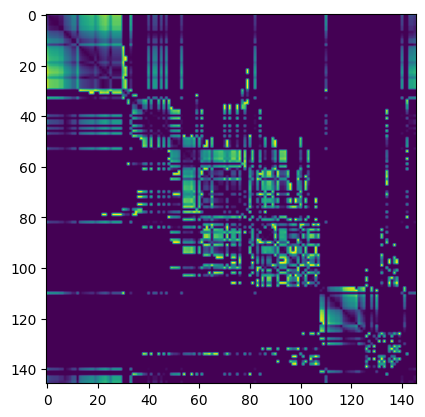

In [25]:
id_to_ord = {d.id : ord for ord, d in enumerate(deliveries)}
ord_to_id = {ord : d.id for ord, d in enumerate(deliveries)}

time_dist = np.zeros((len(deliveries), len(deliveries)))

for i in range(len(deliveries)):
    for j in range(i+1, len(deliveries)):
        d = np.abs((deliveries[i].start_time - deliveries[j].start_time).total_seconds())
        if d / 3600 <= HOUR:
            time_dist[i][j] = time_dist[j][i] = d
        else:
            time_dist[i][j] = time_dist[j][i] = 0
        

plt.imshow(time_dist)

(array([ 55.,  32.,  20.,  82., 104.,  24.,  48.,   0.,   0., 480.]),
 array([ 5. ,  7.4,  9.8, 12.2, 14.6, 17. , 19.4, 21.8, 24.2, 26.6, 29. ]),
 <BarContainer object of 10 artists>)

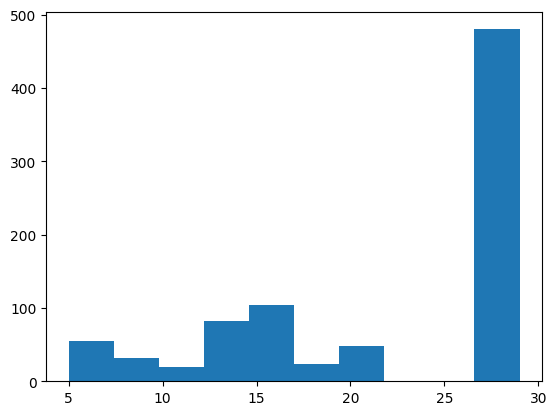

In [26]:
G_time = nx.from_numpy_array(time_dist)
plt.hist([len(c) for c in nx.find_cliques(G_time)])

# Metric graph

Эвристики для вырезании ребер по углу

In [27]:
# Расстояние между заявками для случая с вклиниванием и без
def detect_type(d_1, d_2):
    # Как быть с ориентацией? Быть может это не d_1 -> d_2, а d_2 -> d_1.
    vec_a = np.array(d_1.target_coords) - np.array(d_1.source_coords)
    vec_b = np.array(d_2.source_coords) - np.array(d_1.target_coords)
    orientation = np.inner(vec_a, vec_b)
    if orientation < 0:
        # Имеем дело с вклиниванием заказа 2 в заказ 1
        return True
    else:
        # Заказ 2 обслуживается после заказа 1
        return False
    
def dist_interruption(d_1, d_2, g, id_to_ig, weight='length'):
    full_dist = d_1.km + d_2.km
    # Из начала 1 в начало 2
    path_a = g.distances(
        source=id_to_ig[d_1.source_nodes[0]],
        target=id_to_ig[d_2.source_nodes[0]],
        weights=weight)[0][0]
    # Из начала 2 до первой остановки
    path_b_1 = g.distances(
        source=id_to_ig[d_2.source_nodes[0]],
        target=id_to_ig[d_1.target_nodes[0]],
        weights=weight)[0][0]
    path_b_2 = g.distances(
        source=id_to_ig[d_2.source_nodes[0]],
        target=id_to_ig[d_2.target_nodes[0]],
        weights=weight)[0][0]
    path_b = min(path_b_1, path_b_2)
    # От первой остановки до второй остановки
    if path_b_1 < path_b_2:
        last_source = id_to_ig[d_1.target_nodes[0]]
        last_target = id_to_ig[d_2.target_nodes[0]]
    else:
        last_source = id_to_ig[d_2.target_nodes[0]]
        last_target = id_to_ig[d_1.target_nodes[0]]
    path_c = g.distances(
        source=last_source,
        target=last_target,
        weights=weight)[0][0]
    
    optimised_path = path_a + path_b + path_c
    return full_dist - optimised_path


# def order_dist(d_1, d_2, g, id_to_ig, weight='length'):
#     # 
#     if detect_type(d_1, d_2)

In [28]:
# Пока не используется

def check_angle(d_1, d_2, angle=np.pi, shift = 0.1):
    vec_1 = np.array(d_1.target_coords) - np.array(d_1.source_coords)
    vec_2 = np.array(d_2.target_coords) - np.array(d_2.source_coords)
    ratio = np.linalg.norm(vec_1) / np.linalg.norm(vec_2)
    # Если размеры путей соизмеримы
    if (ratio >= 0.5 - shift) and (ratio <= 0.5 + shift):
        vec_1 /= np.linalg.norm(vec_1)
        vec_2 /= np.linalg.norm(vec_2)
        direction = np.inner(vec_1, vec_2)
        if direction < 0:
            return False
        else:
            if np.arccos(direction) <= angle:
                return True
            else:
                return False
    # Иначе нет смысла смотреть не геометрию
    else:
        return True

Построение графа (пока эвристики вырезаны)

In [29]:
def deliveries_graph(deliveries, g, time_dist = None, weight='length', time_threshold=HOUR, n_jobs=1):
    G = nx.Graph()
    add_edges = []
    # igraph для скорости
    g_ig = igraph.Graph.from_networkx(g)
    id_to_ig = {id:ord for ord, id in enumerate(g.nodes)}

    def process_dist(i):
        res = []
        d_1 = deliveries[i]
        for j in range(i + 1, len(deliveries)):
            d_2 = deliveries[j]
            # Если нет резкого разворота
            # geometry_flag = check_angle(d_1, d_2)
            # geometry_flag = True
            if (time_dist is not None) and (time_dist[id_to_ord[d_1.id], id_to_ord[d_2.id]] > 0):
                dist = g_ig.distances(
                    source=id_to_ig[d_1.target_nodes[0]],
                    target=id_to_ig[d_2.source_nodes[0]],
                    weights=weight
                )[0][0]
                res.append((d_1.id, d_2.id, dist))
        return res
    
    if n_jobs == 1:
        for i in range(len(deliveries)):
            add_edges += process_dist(i)
    else:
        edges = Parallel(n_jobs=n_jobs)(delayed(process_dist)(i) for i in range(len(deliveries)))
        for row in edges:
            add_edges += row
    
    # Можно сделать ориентированным
    G.add_weighted_edges_from(add_edges, weight=weight)
    return G

In [30]:
G_deliveries = deliveries_graph(deliveries, g, time_dist)

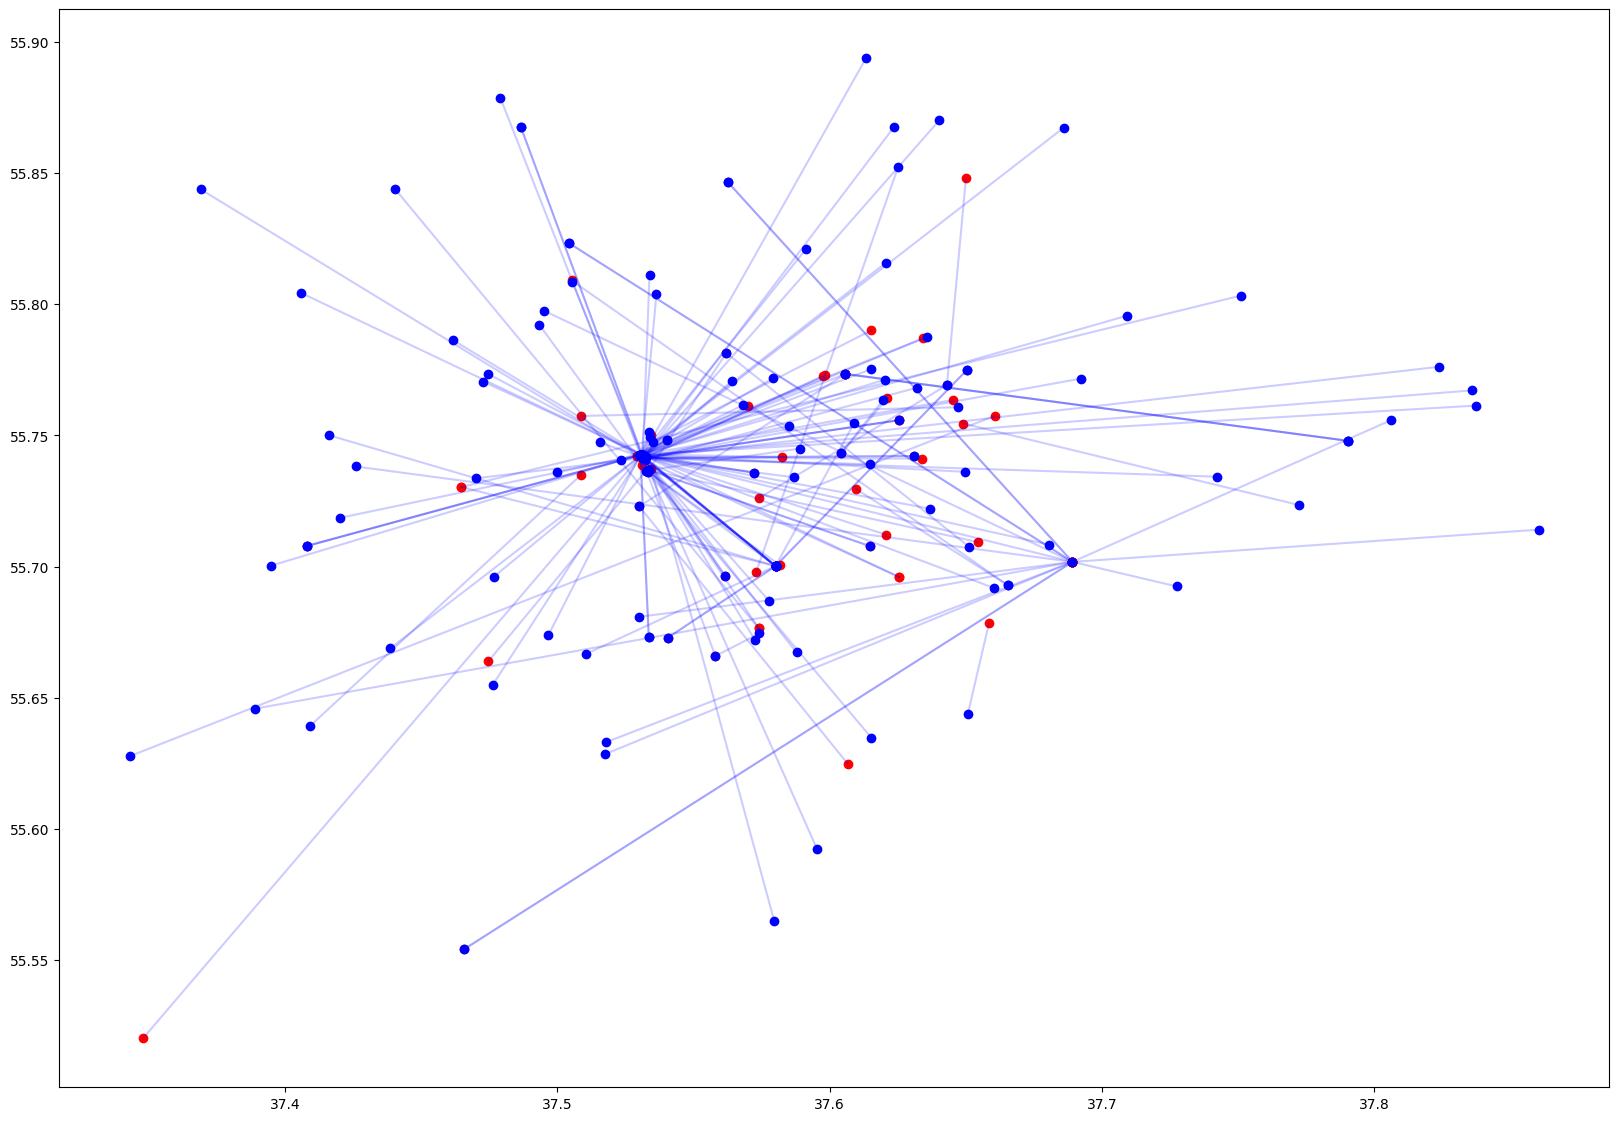

In [31]:
import matplotlib.pyplot as plt

start_points = np.array([d.source_coords for d in deliveries])
end_points = np.array([d.target_coords for d in deliveries])

plt.figure(figsize=(20, 14))
plt.scatter(start_points[:, 0], start_points[:, 1], c='r')
plt.scatter(end_points[:, 0], end_points[:, 1], c='b')

for i in range(len(deliveries)):
    start = start_points[i]
    end = end_points[i]
    plt.plot([start[0], end[0]], [start[1], end[1]], alpha=0.2, c='b')

# Clustering


In [32]:
from random import randint

def plot_communities(G, pos, communities, algo_name=''):
    plt.figure(figsize=(20, 14))

    nx.draw_networkx_edges(G, pos, alpha=0.3)

    for j, cluster in enumerate(communities):
        color = '#%06X' % randint(0, 0xFFFFFF)
        for v in cluster:
            point = pos[v]
            plt.scatter(point[0], point[1], c=color)

    plt.title(f'{algo_name} | {len(communities)} clusters')

## K-medoids

In [33]:
dist_matrix = np.zeros((len(G_deliveries), len(G_deliveries)))

for i, id_1 in enumerate(G_deliveries):
    for j, id_2 in enumerate(G_deliveries):
        if id_2 in G_deliveries._adj[id_1]:
            dist_matrix[i][j] = G_deliveries._adj[id_1][id_2]['length']

n_clusters = 4
dm = kmedoids.dynmsc(dist_matrix, medoids=n_clusters, random_state=0xAB0BA)
clustering = kmedoids.KMedoids(n_clusters=dm.bestk).fit_predict(dist_matrix)

communities = []

for i in np.unique(clustering):
    communities.append([id for j, id in enumerate(G_deliveries) if clustering[j] == i])

clustering_map = {}
for i, c in enumerate(communities):
    for v in c:
        clustering_map[v] = i

nx.community.modularity(G_deliveries, communities, weight='length')

0.1798934903103015

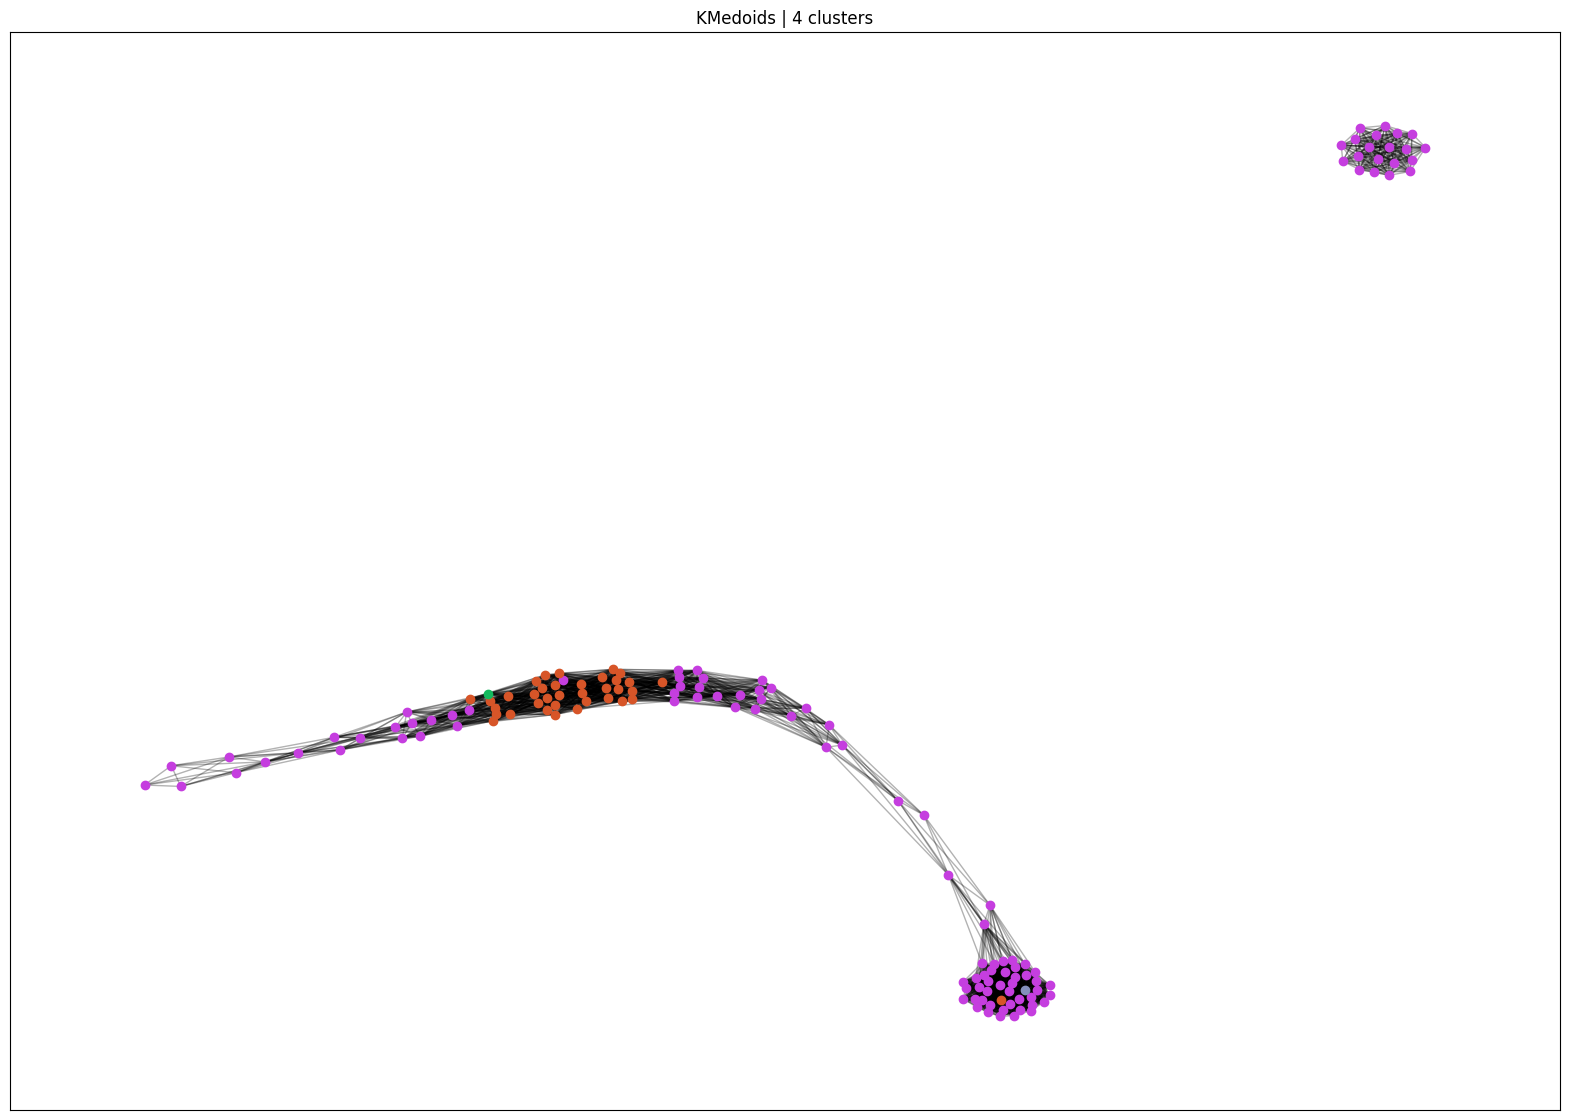

In [34]:
SEED = 0
random.seed(SEED)

pos = nx.layout.spring_layout(G_deliveries, iterations=100, seed=SEED)
plot_communities(G_deliveries, pos, communities, algo_name='KMedoids')

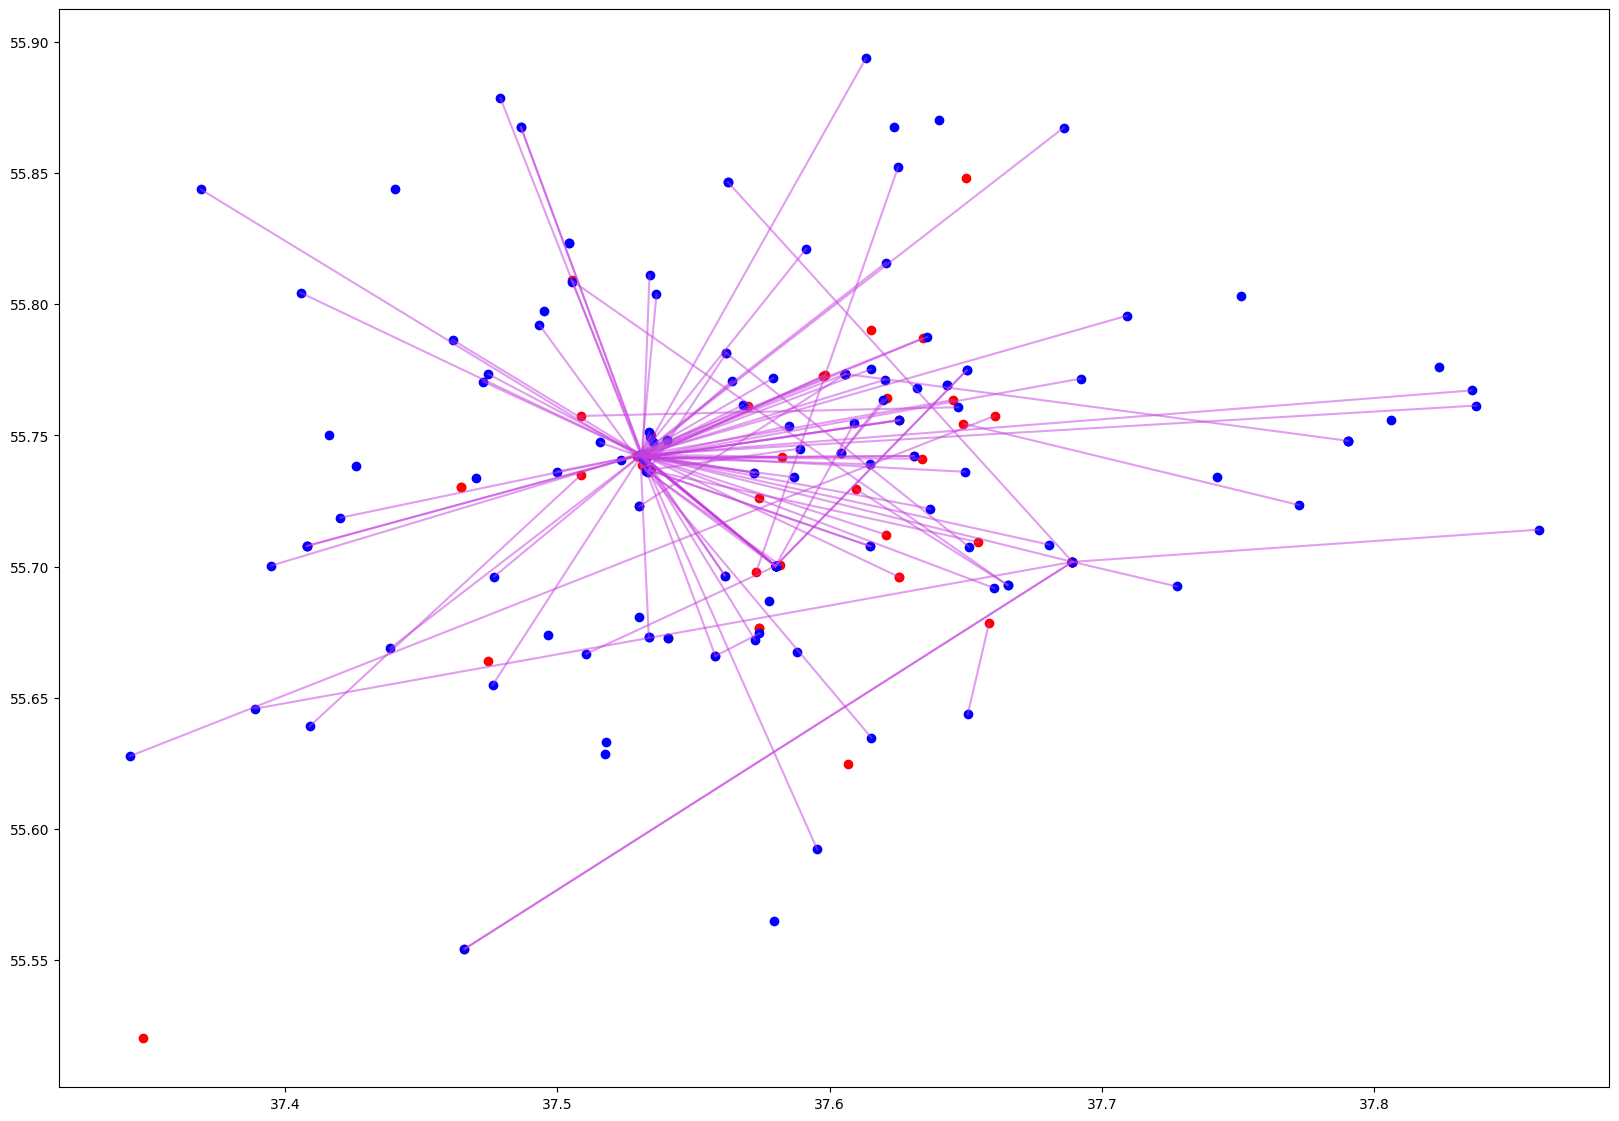

In [35]:
random.seed(0)
chosen_clusters = [0,2] # [i for i in range(len(communities))]

id_subset = []
for i, c in enumerate(communities):
    if i in chosen_clusters:
        id_subset += c
deliveries_subset = [d.id for d in deliveries if d.id in id_subset]

start_points = np.array([d.source_coords for d in deliveries])
end_points = np.array([d.target_coords for d in deliveries])

plt.figure(figsize=(20, 14))
plt.scatter(start_points[:, 0], start_points[:, 1], c='r')
plt.scatter(end_points[:, 0], end_points[:, 1], c='b')

colors = ['#%06X' % random.randint(0, 0xFFFFFF) for _ in communities]
for i, id in enumerate(deliveries_subset):
    start = start_points[i]
    end = end_points[i]
    plt.plot([start[0], end[0]], [start[1], end[1]], alpha=0.5, c=colors[clustering_map[id]])
plt.show()

In [36]:
import time
from copy import deepcopy

start = time.time()
times = []
dg = None
all_routes = []
routes_list: list[Route] = []
log = False
num_workers = 7

# основной цикл решения : разгребаем заявки, пока они не кончается
for d_ in tqdm([[deliveries_dict[d] for d in c] for c in communities]):
    d = deepcopy(d_)
    while len(d) > 0:
        print (len(d), end="\r")
        dg, first_from_node, first_to_node = generate_graph(d, prev_graph=dg, log=log)
        if log:
            print(first_from_node, first_to_node)
        
        start_inner = time.time()
        # вызов модели
        res, starts_sol, u_sol, r_sol, t_sol = do_model_general_x(
            first_from_node, first_to_node,
            dg,
            log=log,
            num_workers=num_workers
        )
        times.append(time.time() - start_inner)
        # получение списка адресов, которые посещаются
        res = flat(res)
        routes = [list(starts_sol)[0]]
        while True:
            if routes[-1] not in res:
                break
            routes.append(res[routes[-1]])
        all_routes.append(routes)
        list_ids = {u[0] for u in routes}
        
        # отсеиваем померженные
        d = list(filter(lambda d: d.id not in list_ids, d))
        if log:
            print(len(d))
        
        routes_list.append(
            Route(
                routes=routes,
                delta_times={(u, v): dg.edges()[u, v]['time'] for u in routes for v in routes if u != v},
                times=t_sol,
                delta_capacity={u: dg.nodes()[u]['delta_capacity'] for u in routes},
                start_times={
                    u: dg.nodes()[u]['start_time'] if dg.nodes()[u]['start'] else dg.nodes()[dg.nodes()[u]['start_node']][
                        'start_time'] for u in routes},
                end_times={u: dg.nodes()[u]['end_time'] for u in routes if not dg.nodes()[u]['start']}
            )
        )
print(time.time() - start)

  0%|          | 0/4 [00:00<?, ?it/s]

284.5006351470947


In [37]:
deliveries = cached_deliveries

total_cost_old = 0
total_len_old = 0
for d in deliveries:
    c, l = get_cost_one(d)
    total_cost_old += c
    total_len_old += l

print(f'Baseline: {len(deliveries)} routes | {total_len_old:.3f} km | {total_cost_old:.3f} rub')

total_cost = 0
total_len = 0
for r in all_routes:
    c, l = get_cost(r)
    total_cost += c
    total_len += l

print(f'Formed {len(all_routes)} routes | {total_len:.3f} km | {total_cost:.3f} rub')
print(f'Optimized cost by {(total_cost_old - total_cost) / total_cost_old}% and distance by {(total_len_old - total_len) / total_len_old}%')

Baseline: 146 routes | 1636.071 km | 153723.547 rub
Formed 102 routes | 1301.045 km | 121447.581 rub
Optimized cost by 0.20996110716347866% and distance by 0.20477443727127081%


In [38]:
draw_on_map(g, all_routes=routes_list)#.save('first_result_short_routes.html')

## Louvain

In [39]:
communities = nx.community.louvain_communities(G_deliveries, weight='length')

nx.community.modularity(G_deliveries, communities, weight='length')

0.5589924215231349

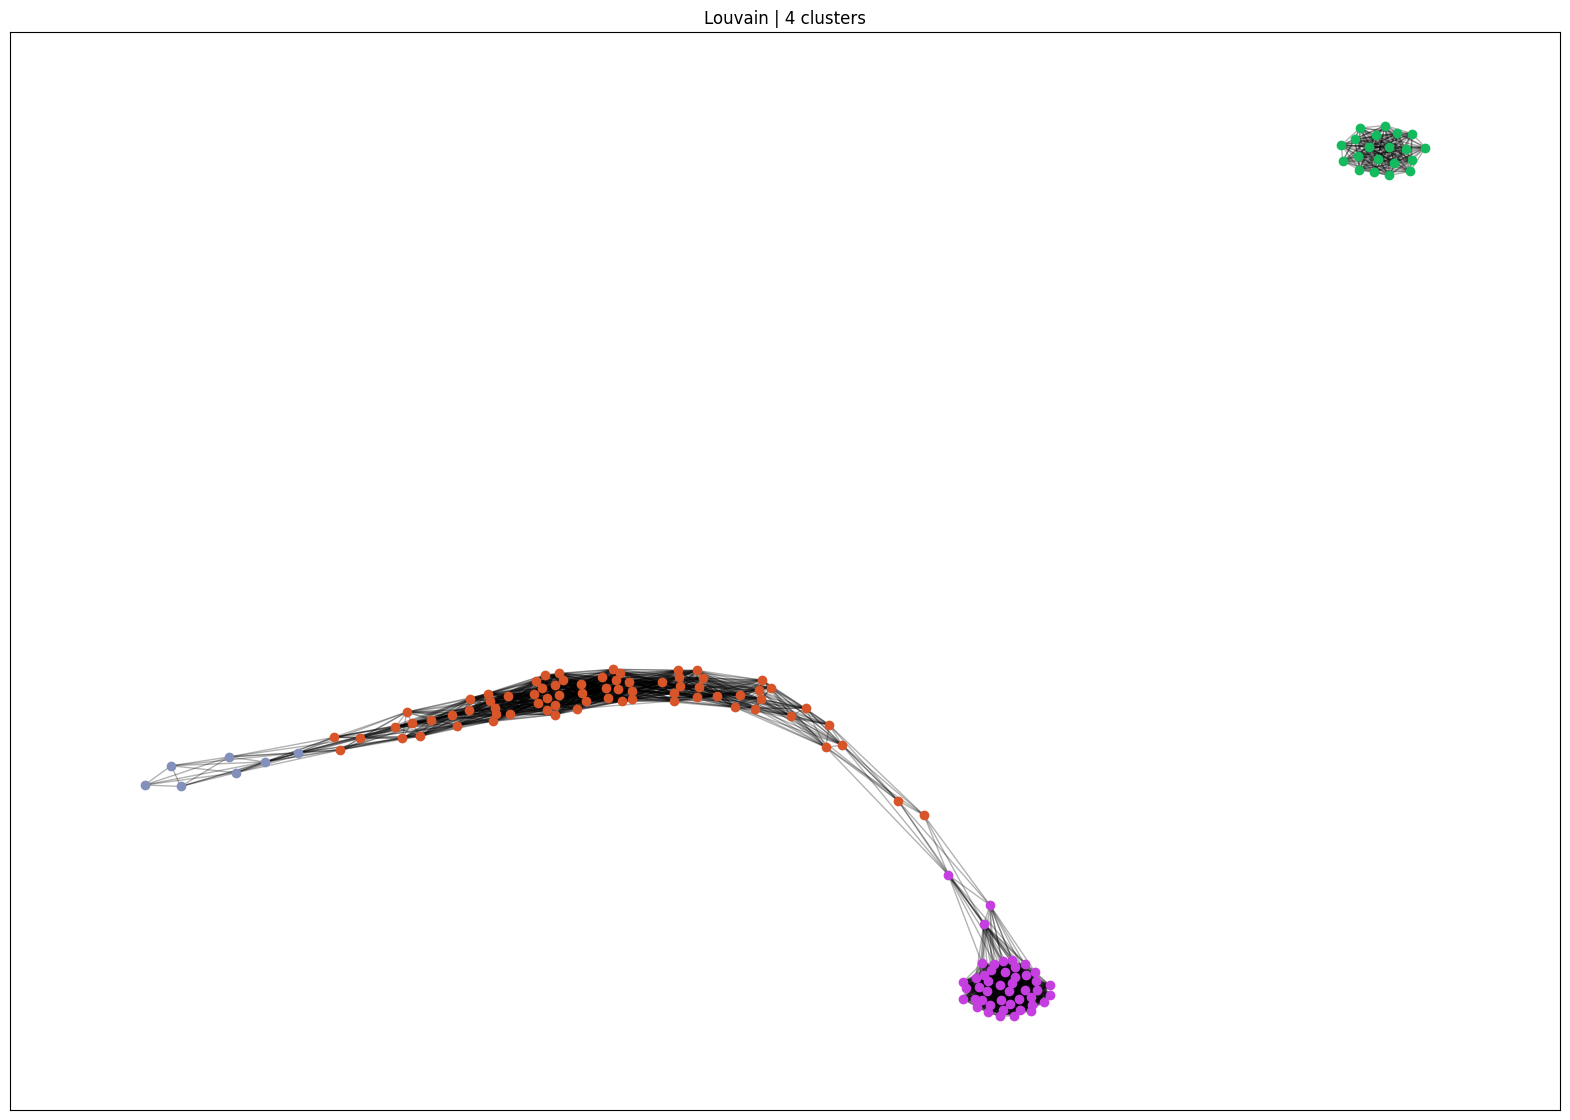

In [40]:
SEED = 0
random.seed(SEED)

pos = nx.layout.spring_layout(G_deliveries, iterations=100, seed=SEED)
plot_communities(G_deliveries, pos, communities, algo_name='Louvain')

In [ ]:
import time
from copy import deepcopy

start = time.time()
times = []
dg = None
all_routes = []
routes_list: list[Route] = []
log = False
num_workers = 7

# основной цикл решения : разгребаем заявки, пока они не кончается
for d_ in tqdm([[deliveries_dict[d] for d in c] for c in communities]):
    d = deepcopy(d_)
    while len(d) > 0:
        print (len(d), end="\r")
        dg, first_from_node, first_to_node = generate_graph(d, prev_graph=dg, log=log)
        if log:
            print(first_from_node, first_to_node)
        
        start_inner = time.time()
        # вызов модели
        res, starts_sol, u_sol, r_sol, t_sol = do_model_general_x(
            first_from_node, first_to_node,
            dg,
            log=log,
            num_workers=num_workers
        )
        times.append(time.time() - start_inner)
        # получение списка адресов, которые посещаются
        res = flat(res)
        routes = [list(starts_sol)[0]]
        while True:
            if routes[-1] not in res:
                break
            routes.append(res[routes[-1]])
        all_routes.append(routes)
        list_ids = {u[0] for u in routes}
        
        # отсеиваем померженные
        d = list(filter(lambda d: d.id not in list_ids, d))
        if log:
            print(len(d))
        
        routes_list.append(
            Route(
                routes=routes,
                delta_times={(u, v): dg.edges()[u, v]['time'] for u in routes for v in routes if u != v},
                times=t_sol,
                delta_capacity={u: dg.nodes()[u]['delta_capacity'] for u in routes},
                start_times={
                    u: dg.nodes()[u]['start_time'] if dg.nodes()[u]['start'] else dg.nodes()[dg.nodes()[u]['start_node']][
                        'start_time'] for u in routes},
                end_times={u: dg.nodes()[u]['end_time'] for u in routes if not dg.nodes()[u]['start']}
            )
        )
print(time.time() - start)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
deliveries = cached_deliveries

total_cost_old = 0
total_len_old = 0
for d in deliveries:
    c, l = get_cost_one(d)
    total_cost_old += c
    total_len_old += l

print(f'Baseline: {len(deliveries)} routes | {total_len_old:.3f} km | {total_cost_old:.3f} rub')

total_cost = 0
total_len = 0
for r in all_routes:
    c, l = get_cost(r)
    total_cost += c
    total_len += l

print(f'Formed {len(all_routes)} routes | {total_len:.3f} km | {total_cost:.3f} rub')
print(f'Optimized cost by {(total_cost_old - total_cost) / total_cost_old}% and distance by {(total_len_old - total_len) / total_len_old}%')

Baseline: 146 routes | 1636.071 km | 153723.547 rub
Formed 99 routes | 1293.266 km | 120578.622 rub
Optimized cost by 0.21561384432169764% and distance by 0.20952937437510097%


In [ ]:
draw_on_map(g, all_routes=routes_list)#.save('first_result_short_routes.html')

## Filtration

### Modularity

In [ ]:
fc = FiltrationClustering(G_deliveries)
communities = fc.cluster(quantiles=np.linspace(1e-1, 1, 1000), n_jobs=7)

nx.community.modularity(G_deliveries, communities, weight='length')

Performing Filtration Clustering


100%|██████████| 1000/1000 [00:28<00:00, 35.71it/s]


Finding best clustering


100%|██████████| 702/702 [00:00<00:00, 1351.30it/s]

Best threshold 13052.7505 with score: 0.552001986601679


0.553328095836379

In [ ]:
SEED = 0
random.seed(SEED)

pos = nx.layout.spring_layout(G_deliveries, iterations=100, seed=SEED)
plot_communities(G_deliveries, pos, communities, algo_name='Filtration on modularity')

NameError: name 'plot_simplex' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
import time
from copy import deepcopy

start = time.time()
times = []
dg = None
all_routes = []
routes_list: list[Route] = []
log = False
num_workers = 7

# основной цикл решения : разгребаем заявки, пока они не кончается
for d_ in tqdm([[deliveries_dict[d] for d in c] for c in communities]):
    d = deepcopy(d_)
    while len(d) > 0:
        print (len(d), end="\r")
        dg, first_from_node, first_to_node = generate_graph(d, prev_graph=dg, log=log)
        if log:
            print(first_from_node, first_to_node)
        
        start_inner = time.time()
        # вызов модели
        res, starts_sol, u_sol, r_sol, t_sol = do_model_general_x(
            first_from_node, first_to_node,
            dg,
            log=log,
            num_workers=num_workers
        )
        times.append(time.time() - start_inner)
        # получение списка адресов, которые посещаются
        res = flat(res)
        routes = [list(starts_sol)[0]]
        while True:
            if routes[-1] not in res:
                break
            routes.append(res[routes[-1]])
        all_routes.append(routes)
        list_ids = {u[0] for u in routes}
        
        # отсеиваем померженные
        d = list(filter(lambda d: d.id not in list_ids, d))
        if log:
            print(len(d))
        
        routes_list.append(
            Route(
                routes=routes,
                delta_times={(u, v): dg.edges()[u, v]['time'] for u in routes for v in routes if u != v},
                times=t_sol,
                delta_capacity={u: dg.nodes()[u]['delta_capacity'] for u in routes},
                start_times={
                    u: dg.nodes()[u]['start_time'] if dg.nodes()[u]['start'] else dg.nodes()[dg.nodes()[u]['start_node']][
                        'start_time'] for u in routes},
                end_times={u: dg.nodes()[u]['end_time'] for u in routes if not dg.nodes()[u]['start']}
            )
        )
print(time.time() - start)

  0%|          | 0/3 [00:00<?, ?it/s]

343.3122818470001


In [ ]:
deliveries = cached_deliveries

total_cost_old = 0
total_len_old = 0
for d in deliveries:
    c, l = get_cost_one(d)
    total_cost_old += c
    total_len_old += l

print(f'Baseline: {len(deliveries)} routes | {total_len_old:.3f} km | {total_cost_old:.3f} rub')

total_cost = 0
total_len = 0
for r in all_routes:
    c, l = get_cost(r)
    total_cost += c
    total_len += l

print(f'Formed {len(all_routes)} routes | {total_len:.3f} km | {total_cost:.3f} rub')
print(f'Optimized cost by {(total_cost_old - total_cost) / total_cost_old}% and distance by {(total_len_old - total_len) / total_len_old}%')

Baseline: 146 routes | 1636.071 km | 153723.547 rub
Formed 100 routes | 1293.886 km | 120879.873 rub
Optimized cost by 0.21365415001961569% and distance by 0.2091502303167847%


In [ ]:
draw_on_map(g, all_routes=routes_list)#.save('first_result_short_routes.html')

### Constant Potts Model

In [ ]:
fc = FiltrationClustering(G_deliveries)
communities = fc.cluster(quantiles=np.linspace(1e-1, 1, 1000), n_jobs=7, metric='cpm')

nx.community.modularity(G_deliveries, communities, weight='length')

Performing Filtration Clustering


100%|██████████| 1000/1000 [00:28<00:00, 35.71it/s]


Finding best clustering


100%|██████████| 702/702 [00:00<00:00, 1351.30it/s]

Best threshold 13052.7505 with score: 0.552001986601679


0.553328095836379

In [ ]:
SEED = 0
random.seed(SEED)

pos = nx.layout.spring_layout(G_deliveries, iterations=100, seed=SEED)
plot_communities(G_deliveries, pos, communities, algo_name='Filtration on CPM')

NameError: name 'plot_simplex' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
import time
from copy import deepcopy

start = time.time()
times = []
dg = None
all_routes = []
routes_list: list[Route] = []
log = False
num_workers = 7

# основной цикл решения : разгребаем заявки, пока они не кончается
for d_ in tqdm([[deliveries_dict[d] for d in c] for c in communities]):
    d = deepcopy(d_)
    while len(d) > 0:
        print (len(d), end="\r")
        dg, first_from_node, first_to_node = generate_graph(d, prev_graph=dg, log=log)
        if log:
            print(first_from_node, first_to_node)
        
        start_inner = time.time()
        # вызов модели
        res, starts_sol, u_sol, r_sol, t_sol = do_model_general_x(
            first_from_node, first_to_node,
            dg,
            log=log,
            num_workers=num_workers
        )
        times.append(time.time() - start_inner)
        # получение списка адресов, которые посещаются
        res = flat(res)
        routes = [list(starts_sol)[0]]
        while True:
            if routes[-1] not in res:
                break
            routes.append(res[routes[-1]])
        all_routes.append(routes)
        list_ids = {u[0] for u in routes}
        
        # отсеиваем померженные
        d = list(filter(lambda d: d.id not in list_ids, d))
        if log:
            print(len(d))
        
        routes_list.append(
            Route(
                routes=routes,
                delta_times={(u, v): dg.edges()[u, v]['time'] for u in routes for v in routes if u != v},
                times=t_sol,
                delta_capacity={u: dg.nodes()[u]['delta_capacity'] for u in routes},
                start_times={
                    u: dg.nodes()[u]['start_time'] if dg.nodes()[u]['start'] else dg.nodes()[dg.nodes()[u]['start_node']][
                        'start_time'] for u in routes},
                end_times={u: dg.nodes()[u]['end_time'] for u in routes if not dg.nodes()[u]['start']}
            )
        )
print(time.time() - start)

  0%|          | 0/3 [00:00<?, ?it/s]

343.3122818470001


In [ ]:
deliveries = cached_deliveries

total_cost_old = 0
total_len_old = 0
for d in deliveries:
    c, l = get_cost_one(d)
    total_cost_old += c
    total_len_old += l

print(f'Baseline: {len(deliveries)} routes | {total_len_old:.3f} km | {total_cost_old:.3f} rub')

total_cost = 0
total_len = 0
for r in all_routes:
    c, l = get_cost(r)
    total_cost += c
    total_len += l

print(f'Formed {len(all_routes)} routes | {total_len:.3f} km | {total_cost:.3f} rub')
print(f'Optimized cost by {(total_cost_old - total_cost) / total_cost_old}% and distance by {(total_len_old - total_len) / total_len_old}%')

Baseline: 146 routes | 1636.071 km | 153723.547 rub
Formed 100 routes | 1293.886 km | 120879.873 rub
Optimized cost by 0.21365415001961569% and distance by 0.2091502303167847%


In [ ]:
draw_on_map(g, all_routes=routes_list)#.save('first_result_short_routes.html')

## Leiden

In [61]:
def get_communities(g, partition):
    # Collect corresponding nodes
    communities = []
    for community in partition:
        node_set = set()
        for v in community:
            node_set.add(g.vs[v]['_nx_name'])
        communities.append(node_set)
    return communities


seed = 0xAB0BA
communities = leiden(G_deliveries, partition_type=la.ModularityVertexPartition, seed=seed, weights='length')
# partition = la.find_partition(G_deliveries, partition_type=la.ModularityVertexPartition, seed=seed, weights='length')
# communities = get_communities(G_deliveries, partition)

nx.community.modularity(G_deliveries, communities, weight='length')

0.5602242206004554

  0%|          | 0/4 [00:00<?, ?it/s]

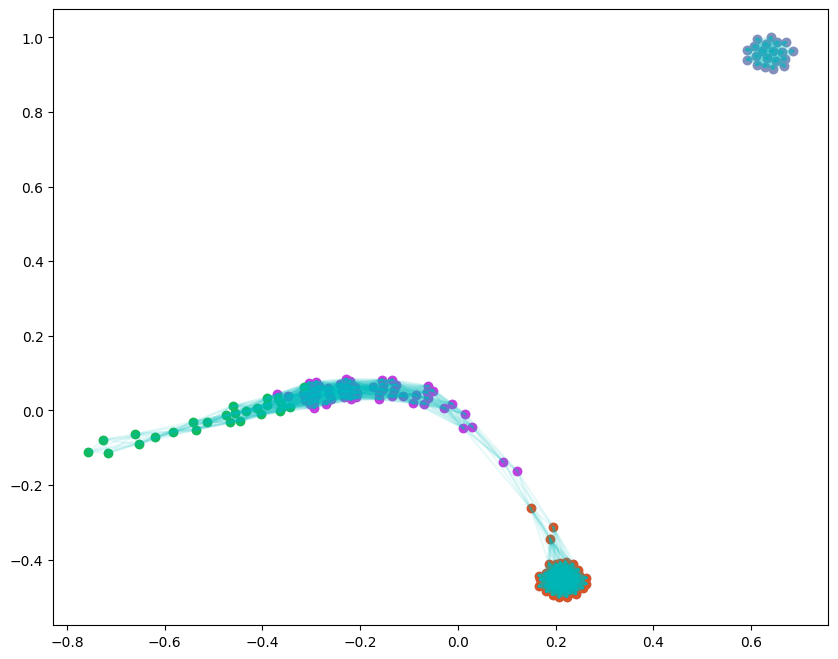

In [62]:
SEED = 0
random.seed(SEED)

pos = nx.layout.spring_layout(G_deliveries, iterations=100, seed=SEED)
plot_communities(G_deliveries, communities, pos)

In [63]:
import time
from copy import deepcopy

start = time.time()
times = []
dg = None
all_routes = []
routes_list: list[Route] = []
log = False
num_workers = 7

# основной цикл решения : разгребаем заявки, пока они не кончается
for d_ in tqdm([[deliveries_dict[d] for d in c] for c in communities]):
    d = deepcopy(d_)
    while len(d) > 0:
        print (len(d), end="\r")
        dg, first_from_node, first_to_node = generate_graph(d, prev_graph=dg, log=log)
        if log:
            print(first_from_node, first_to_node)
        
        start_inner = time.time()
        # вызов модели
        res, starts_sol, u_sol, r_sol, t_sol = do_model_general_x(
            first_from_node, first_to_node,
            dg,
            log=log,
            num_workers=num_workers
        )
        times.append(time.time() - start_inner)
        # получение списка адресов, которые посещаются
        res = flat(res)
        routes = [list(starts_sol)[0]]
        while True:
            if routes[-1] not in res:
                break
            routes.append(res[routes[-1]])
        all_routes.append(routes)
        list_ids = {u[0] for u in routes}
        
        # отсеиваем померженные
        d = list(filter(lambda d: d.id not in list_ids, d))
        if log:
            print(len(d))
        
        routes_list.append(
            Route(
                routes=routes,
                delta_times={(u, v): dg.edges()[u, v]['time'] for u in routes for v in routes if u != v},
                times=t_sol,
                delta_capacity={u: dg.nodes()[u]['delta_capacity'] for u in routes},
                start_times={
                    u: dg.nodes()[u]['start_time'] if dg.nodes()[u]['start'] else dg.nodes()[dg.nodes()[u]['start_node']][
                        'start_time'] for u in routes},
                end_times={u: dg.nodes()[u]['end_time'] for u in routes if not dg.nodes()[u]['start']}
            )
        )
print(time.time() - start)

  0%|          | 0/4 [00:00<?, ?it/s]

308.0906629562378


In [64]:
deliveries = cached_deliveries

total_cost_old = 0
total_len_old = 0
for d in deliveries:
    c, l = get_cost_one(d)
    total_cost_old += c
    total_len_old += l

print(f'Baseline: {len(deliveries)} routes | {total_len_old:.3f} km | {total_cost_old:.3f} rub')

total_cost = 0
total_len = 0
for r in all_routes:
    c, l = get_cost(r)
    total_cost += c
    total_len += l

print(f'Formed {len(all_routes)} routes | {total_len:.3f} km | {total_cost:.3f} rub')
print(f'Optimized cost by {(total_cost_old - total_cost) / total_cost_old}% and distance by {(total_len_old - total_len) / total_len_old}%')

Baseline: 146 routes | 1636.071 km | 153723.547 rub
Formed 100 routes | 1291.947 km | 120564.953 rub
Optimized cost by 0.21570276207952666% and distance by 0.21033580658799908%


In [65]:
draw_on_map(g, all_routes=routes_list)#.save('first_result_short_routes.html')

### Leiden on multiset
Возьми фильтрацию и откластеризуй через Leiden

In [ ]:
ig_2_networkx = {ord : id for ord, id in enumerate(G_deliveries.nodes)}
networkx_2_ig = {id : ord for ord, id in enumerate(G_deliveries.nodes)}

def get_filtration_graphs(G, q=np.linspace(1e-1, 1, 2)):
    # Выбрать основные моменты фильтрации через свою кластеризацию (лучшая модулярность)
    graph_arr = []
    levels = sorted([data['length'] for _,_, data in G.edges(data=True)])
    A = nx.adjacency_matrix(G_deliveries, weight='length').toarray()
    for threshold in np.quantile(levels, q=q)[::-1]:
        A[A < threshold] = 0
        graph_arr.append(
            ig.Graph.from_networkx(
                nx.from_numpy_array(A, edge_attr='length')
            )
        )
    return graph_arr

In [ ]:
communities = filtration_clustering(G_deliveries, q=np.linspace(1e-2, 1, 1000), )

nx.community.modularity(G_deliveries, communities, weight='length')

In [77]:
membership, improv = la.find_partition_multiplex(
    get_filtration_graphs(G_deliveries, q=np.linspace(1e-1, 1, 3)),
    la.ModularityVertexPartition, weights='length'
)

In [78]:
membership

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 0,
 142,
 143,
 0,
 144]

In [63]:
communities = []
for label in np.unique(membership):
    communities.append(
        [ig_2_networkx[v] for v in np.where(membership == label)[0]]
    )

communities

[['OT-0001-00128760', 'OT-0001-00128571'],
 ['OT-0001-00129115'],
 ['OT-0001-00129112'],
 ['OT-0001-00129111'],
 ['OT-0001-00129110'],
 ['OT-0001-00129109'],
 ['OT-0001-00129107'],
 ['OT-0001-00129106'],
 ['OT-0001-00129100'],
 ['OT-0001-00129097'],
 ['OT-0001-00129096'],
 ['OT-0001-00129095'],
 ['OT-0001-00129094'],
 ['OT-0001-00129093'],
 ['OT-0001-00129092'],
 ['OT-0001-00129090'],
 ['OT-0001-00129089'],
 ['OT-0001-00129088'],
 ['OT-0001-00129087'],
 ['OT-0001-00129086'],
 ['OT-0001-00129084'],
 ['OT-0001-00129083'],
 ['OT-0001-00129081'],
 ['OT-0001-00129079'],
 ['OT-0001-00129078'],
 ['OT-0001-00129077'],
 ['OT-0001-00129072'],
 ['OT-0001-00129071'],
 ['OT-0001-00129069'],
 ['OT-0001-00129067'],
 ['OT-0001-00129064'],
 ['OT-0001-00129042'],
 ['OT-0001-00129007'],
 ['OT-0001-00129005'],
 ['OT-0001-00129004'],
 ['OT-0001-00129002'],
 ['OT-0001-00128995'],
 ['OT-0001-00128983'],
 ['OT-0001-00128927'],
 ['OT-0001-00128823'],
 ['OT-0001-00128375'],
 ['OT-0001-00126289'],
 ['OT-0001-001